# 第8章: ニューラルネット

In [ ]:
##データをダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

In [ ]:
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

## 70. 単語ベクトルの和による特徴量

In [1]:
#インポート
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]
# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

In [3]:
from gensim.models import KeyedVectors

In [4]:
#Word2vecのモデルを作る
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [5]:
import string
import torch

In [6]:
def transform_w2v(text):
    #記号を消す
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    #スペースで区切る
    words = text.translate(table).split()
    #1単語ずつベクトルにする
    vec = [model[word] for word in words if word in model]
    
    return torch.tensor(sum(vec) / len(vec))

In [7]:
#特徴ベクトルを並べた行列を作る
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

In [8]:
#カテゴリーと数字の対応関係
category_dict = {'b' : 0, 't' : 1, 'e' : 2, 'm' : 3}

In [9]:
#正解ラベルを並べた行列を作る
y_train = torch.tensor(train['CATEGORY'].map(lambda x : category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x : category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x : category_dict[x]).values)

In [10]:
#保存する
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

## 71. 単層ニューラルネットワークによる予測

In [11]:
from torch import nn

In [12]:
#単層ニューラルネットワーク を作る
class SLPNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        nn.init.normal_(self.fc.weight, 0.0, 1.0)
        
    def forward(self, x):
        x = self.fc(x)
        return x

In [13]:
#y_hat_1を求める

#ニューラルネットワーク
net = SLPNet(300, 4)
y_hat_1 = torch.softmax(net(X_train[:1]), dim=-1)
print(y_hat_1)

tensor([[0.5941, 0.0271, 0.2973, 0.0816]], grad_fn=<SoftmaxBackward>)


In [14]:
#Y_hatを求める

Y_hat = torch.softmax(net(X_train[:4]), dim=-1)
print(Y_hat)

tensor([[0.5941, 0.0271, 0.2973, 0.0816],
        [0.0164, 0.0313, 0.7799, 0.1724],
        [0.0710, 0.0314, 0.7617, 0.1359],
        [0.5492, 0.0083, 0.3428, 0.0998]], grad_fn=<SoftmaxBackward>)


## 72. 損失と勾配の計算

In [15]:
#クロスエントロピー損失
criterion = nn.CrossEntropyLoss()
loss_1 = criterion(net(X_train[:1]), y_train[:1])
loss_1.backward()
print(f'損失: {loss_1:.4f}')
print(f'勾配:\n {net.fc.weight.grad}')

損失: 0.5207
勾配:
 tensor([[-0.0340, -0.0023, -0.0028,  ..., -0.0305, -0.0176,  0.0352],
        [ 0.0023,  0.0002,  0.0002,  ...,  0.0020,  0.0012, -0.0023],
        [ 0.0249,  0.0017,  0.0020,  ...,  0.0223,  0.0129, -0.0258],
        [ 0.0068,  0.0005,  0.0006,  ...,  0.0061,  0.0035, -0.0071]])


In [16]:
loss = criterion(net(X_train[:4]), y_train[:4])
loss.backward()
print(f'損失: {loss:.4f}')
print(f'勾配:\n {net.fc.weight.grad}')

損失: 1.7627
勾配:
 tensor([[-4.8937e-02,  3.7776e-03,  3.2828e-03,  ..., -4.1161e-02,
         -1.4638e-02,  4.2724e-02],
        [-3.4154e-03, -6.2613e-03,  2.2682e-02,  ...,  2.7522e-02,
          1.4358e-02, -5.9162e-05],
        [ 5.6495e-02, -3.9009e-03, -4.0966e-02,  ...,  1.7435e-03,
          2.3551e-02, -1.3969e-02],
        [-4.1434e-03,  6.3846e-03,  1.5001e-02,  ...,  1.1896e-02,
         -2.3271e-02, -2.8695e-02]])


## 73. 確率的勾配降下法による学習

In [17]:
from torch.utils.data import Dataset

In [18]:
#データセットを作る

class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [19]:
train_ds = NewsDataset(X_train, y_train)
valid_ds = NewsDataset(X_valid, y_valid)
test_ds = NewsDataset(X_test, y_test)

#DataLoaderを作る
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

In [20]:
net = SLPNet(300, 4)

criterion = nn.CrossEntropyLoss()

#optimizerを作る
optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)

num_epochs = 10


for epoch in range(num_epochs):
    #モデルを訓練モードにする
    net.train()
    #エポックの損失和
    loss_train = 0.0
    
    for i, (inputs, labels) in enumerate(train_dl):
        #optimizerを初期化する
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        #バックプロパゲーション
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item()
        
    loss_train = loss_train / i
    #モデルを評価モードにする
    net.eval()
    
    with torch.no_grad():
        inputs, labels = next(iter(valid_dl))
        outputs = net(inputs)
        loss_valid = criterion(outputs, labels)
        
    print('Epoch {}/{} | loss_train : {:.4f} | loss_valid : {:.4f}'.format(epoch+1, num_epochs, loss_train, loss_valid))

Epoch 1/10 | loss_train : 0.4567 | loss_valid : 0.3641
Epoch 2/10 | loss_train : 0.3110 | loss_valid : 0.3334
Epoch 3/10 | loss_train : 0.2821 | loss_valid : 0.3216
Epoch 4/10 | loss_train : 0.2662 | loss_valid : 0.3173
Epoch 5/10 | loss_train : 0.2560 | loss_valid : 0.3153
Epoch 6/10 | loss_train : 0.2489 | loss_valid : 0.3135
Epoch 7/10 | loss_train : 0.2431 | loss_valid : 0.3144
Epoch 8/10 | loss_train : 0.2390 | loss_valid : 0.3153
Epoch 9/10 | loss_train : 0.2361 | loss_valid : 0.3117
Epoch 10/10 | loss_train : 0.2330 | loss_valid : 0.3138


## 74. 正解率の計測

In [21]:
#正解率を計算する
def calc_accuracy(net, dataloader):
    net.eval()
    total = 0
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = net(inputs)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
            
    return correct / total

In [22]:
accuracy_train = calc_accuracy(net, train_dl)
accuracy_test = calc_accuracy(net, test_dl)

print('正解率(学習データ): {:.4f}'.format(accuracy_train))
print('正解率(評価データ): {:.4f}'.format(accuracy_test))

正解率(学習データ): 0.9226
正解率(評価データ): 0.9064


## 75. 損失と正解率のプロット

In [23]:
#損失と正解率を計算する
def calc_loss_accuracy(net, dataloader, criterion):
    net.eval()
    loss = 0.0
    total = 0
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = net(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
            
    return loss / len(dataloader), correct/total

In [24]:
#モデルを作る
net = SLPNet(300, 4)
#criterionを作る
criterion = nn.CrossEntropyLoss()
#optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)

num_epochs = 30

#訓練データと検証データの損失と正解率を記録する
log_train = []
log_valid = []

for epoch in range(num_epochs):
    
    
    net.train()
    loss_train = 0.0
    
    for i, (inputs, labels) in enumerate(train_dl):
    
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    
    loss_train, acc_train = calc_loss_accuracy(net, train_dl, criterion)
    loss_valid, acc_valid = calc_loss_accuracy(net, valid_dl, criterion)
    
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])
    
        
    print('Epoch {}/{} | loss_train : {:.4f} | acc_train : {:.4f} | loss_valid : {:.4f} | acc_valid : {:.4f}'.format(epoch+1, num_epochs, loss_train, acc_train, loss_valid, acc_valid))

Epoch 1/30 | loss_train : 0.3307 | acc_train : 0.8819 | loss_valid : 0.3532 | acc_valid : 0.8683
Epoch 2/30 | loss_train : 0.2881 | acc_train : 0.9026 | loss_valid : 0.3194 | acc_valid : 0.9004
Epoch 3/30 | loss_train : 0.2694 | acc_train : 0.9077 | loss_valid : 0.3127 | acc_valid : 0.8862
Epoch 4/30 | loss_train : 0.2546 | acc_train : 0.9119 | loss_valid : 0.3065 | acc_valid : 0.8952
Epoch 5/30 | loss_train : 0.2439 | acc_train : 0.9177 | loss_valid : 0.2990 | acc_valid : 0.9019
Epoch 6/30 | loss_train : 0.2378 | acc_train : 0.9203 | loss_valid : 0.2994 | acc_valid : 0.9012
Epoch 7/30 | loss_train : 0.2334 | acc_train : 0.9217 | loss_valid : 0.2993 | acc_valid : 0.8997
Epoch 8/30 | loss_train : 0.2303 | acc_train : 0.9226 | loss_valid : 0.3008 | acc_valid : 0.8975
Epoch 9/30 | loss_train : 0.2287 | acc_train : 0.9244 | loss_valid : 0.3038 | acc_valid : 0.9004
Epoch 10/30 | loss_train : 0.2255 | acc_train : 0.9226 | loss_valid : 0.3046 | acc_valid : 0.8997
Epoch 11/30 | loss_train : 0.

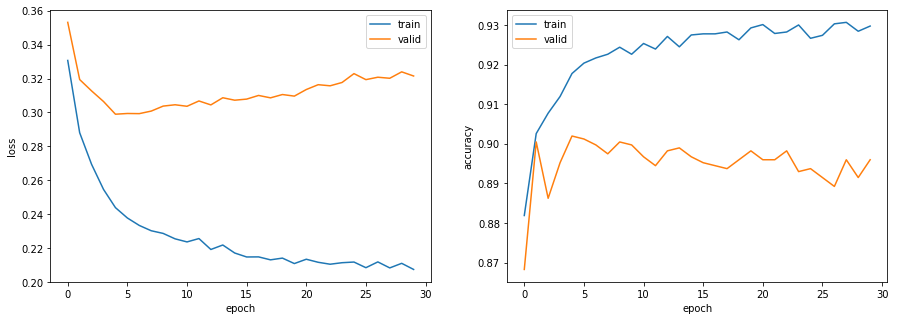

In [25]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

## 76. チェックポイント

In [26]:
net = SLPNet(300, 4)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)

num_epochs = 30
log_train = []
log_valid = []

for epoch in range(num_epochs):
    
    
    net.train()
    loss_train = 0.0
    
    for i, (inputs, labels) in enumerate(train_dl):
    
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    
    loss_train, acc_train = calc_loss_accuracy(net, train_dl, criterion)
    loss_valid, acc_valid = calc_loss_accuracy(net, valid_dl, criterion)
    
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])
    
    #エポックごとに記録
    torch.save({'epoch': epoch, 'model_state_dict': net.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
    
        
    print('Epoch {}/{} | loss_train : {:.4f} | acc_train : {:.4f} | loss_valid : {:.4f} | acc_valid : {:.4f}'.format(epoch+1, num_epochs, loss_train, acc_train, loss_valid, acc_valid))

Epoch 1/30 | loss_train : 0.3417 | acc_train : 0.8812 | loss_valid : 0.3624 | acc_valid : 0.8810
Epoch 2/30 | loss_train : 0.2841 | acc_train : 0.9036 | loss_valid : 0.3164 | acc_valid : 0.8945
Epoch 3/30 | loss_train : 0.2661 | acc_train : 0.9099 | loss_valid : 0.3060 | acc_valid : 0.8997
Epoch 4/30 | loss_train : 0.2534 | acc_train : 0.9125 | loss_valid : 0.3038 | acc_valid : 0.9004
Epoch 5/30 | loss_train : 0.2453 | acc_train : 0.9186 | loss_valid : 0.3006 | acc_valid : 0.9042
Epoch 6/30 | loss_train : 0.2419 | acc_train : 0.9178 | loss_valid : 0.3042 | acc_valid : 0.8990
Epoch 7/30 | loss_train : 0.2355 | acc_train : 0.9196 | loss_valid : 0.3049 | acc_valid : 0.8997
Epoch 8/30 | loss_train : 0.2308 | acc_train : 0.9217 | loss_valid : 0.2992 | acc_valid : 0.9004
Epoch 9/30 | loss_train : 0.2273 | acc_train : 0.9244 | loss_valid : 0.3017 | acc_valid : 0.8975
Epoch 10/30 | loss_train : 0.2248 | acc_train : 0.9240 | loss_valid : 0.3009 | acc_valid : 0.9004
Epoch 11/30 | loss_train : 0.

## 77. ミニバッチ化

In [27]:
import time
def train_model(net, train_ds, dataset_dl, criterion, optimizer, num_epochs, batch_size):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)
    
    log_train = []
    log_valid = []
    
    for epoch in range(num_epochs):
        net.train()
        #開始時間
        start_time = time.time()
        
        for inputs, labels in train_dl:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            
        loss_train, acc_train = calc_loss_accuracy(net, train_dl, criterion)
        loss_valid, acc_valid = calc_loss_accuracy(net, valid_dl, criterion)
    
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])
    
        torch.save({'epoch': epoch, 'model_state_dict': net.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
        #終了時間
        end_time = time.time()
        
        print('Epoch {}/{} | loss_train : {:.4f} | acc_train : {:.4f} | loss_valid : {:.4f} | acc_valid : {:.4f} | time : {:.4f}'.format(epoch+1, num_epochs, loss_train, acc_train, loss_valid, acc_valid, (end_time - start_time)))
    return {'train' : log_train, 'valid' : log_valid}   

In [28]:

net = SLPNet(300, 4)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)
num_epochs = 1

for batch_size in [2**i for i in range(11)]:
    print('バッチサイズ : ', batch_size)
    log = train_model(net, train_ds, valid_ds, criterion, optimizer, num_epochs, batch_size)

バッチサイズ :  1
Epoch 1/1 | loss_train : 0.3373 | acc_train : 0.8830 | loss_valid : 0.3612 | acc_valid : 0.8750 | time : 4.1328
バッチサイズ :  2
Epoch 1/1 | loss_train : 0.3052 | acc_train : 0.8947 | loss_valid : 0.3376 | acc_valid : 0.8855 | time : 1.8343
バッチサイズ :  4
Epoch 1/1 | loss_train : 0.2951 | acc_train : 0.8975 | loss_valid : 0.3300 | acc_valid : 0.8870 | time : 1.0154
バッチサイズ :  8
Epoch 1/1 | loss_train : 0.2912 | acc_train : 0.8996 | loss_valid : 0.3277 | acc_valid : 0.8862 | time : 0.5865
バッチサイズ :  16
Epoch 1/1 | loss_train : 0.2891 | acc_train : 0.8999 | loss_valid : 0.3265 | acc_valid : 0.8892 | time : 0.4275
バッチサイズ :  32
Epoch 1/1 | loss_train : 0.2884 | acc_train : 0.8998 | loss_valid : 0.3259 | acc_valid : 0.8892 | time : 0.2690
バッチサイズ :  64
Epoch 1/1 | loss_train : 0.2877 | acc_train : 0.9001 | loss_valid : 0.3256 | acc_valid : 0.8900 | time : 0.1954
バッチサイズ :  128
Epoch 1/1 | loss_train : 0.2872 | acc_train : 0.9004 | loss_valid : 0.3255 | acc_valid : 0.8907 | time : 0.1529
バッチ

## 78. GPU上での学習

In [29]:
def calc_loss_accuracy(net, dataloader, criterion, device):
    net.eval()
    loss = 0.0
    total = 0
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            #inputsとlabelsをdeviceに送る
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = net(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
            
    return loss / len(dataloader), correct/total

def train_model(net, train_ds, dataset_dl, criterion, optimizer, num_epochs, batch_size, device):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)
    
    log_train = []
    log_valid = []
    #モデルをdeviceに送る
    net.to(device)
    
    for epoch in range(num_epochs):
        net.train()
        start_time = time.time()
        
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = net.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            
        loss_train, acc_train = calc_loss_accuracy(net, train_dl, criterion, device)
        loss_valid, acc_valid = calc_loss_accuracy(net, valid_dl, criterion, device)
    
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])
    
        torch.save({'epoch': epoch, 'model_state_dict': net.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
        
        end_time = time.time()
        
        print('Epoch {}/{} | loss_train : {:.4f} | acc_train : {:.4f} | loss_valid : {:.4f} | acc_valid : {:.4f} | time : {:.4f}'.format(epoch+1, num_epochs, loss_train, acc_train, loss_valid, acc_valid, (end_time - start_time)))
    return {'train' : log_train, 'valid' : log_valid}   

In [ ]:
net = SLPNet(300, 4)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)
num_epochs = 1

#GPUが使用可能ならば使用する
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('使用デバイス: ',device)
print('---start---')

for batch_size in [2**i for i in range(11)]:
    print('バッチサイズ : ', batch_size)
    log = train_model(net, train_ds, valid_ds, criterion, optimizer, num_epochs, batch_size, device)

使用デバイス:  cuda:0
---start---
バッチサイズ :  1


## 79. 多層ニューラルネットワーク

In [ ]:
#多層ニューラルネットワーク
from torch.nn import functional as F
class MLPNet(nn.Module):
    def __init__(self, input_size, mid_size, output_size, num_mid_layers):
        super().__init__()
        self.num_mid_layers = num_mid_layers
        self.fc = nn.Linear(input_size, mid_size)
        self.fc_mid = nn.Linear(mid_size, mid_size)
        self.fc_out = nn.Linear(mid_size, output_size)
        self.bn = nn.BatchNorm1d(mid_size)
        
    def forward(self, x):
        x = F.relu(self.fc(x))
        for _ in range(self.num_mid_layers):
            x = F.relu(self.bn(self.fc_mid(x)))
        x = F.relu(self.fc_out(x))
        return x

In [ ]:
def train_model(net, train_ds, dataset_dl, criterion, optimizer, num_epochs, batch_size, device):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)
    
    log_train = []
    log_valid = []
    
    net.to(device)
    
    
    #schedulerを作る(StepLR使用)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    for epoch in range(num_epochs):
        net.train()
        start_time = time.time()
        
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = net.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            
        loss_train, acc_train = calc_loss_accuracy(net, train_dl, criterion, device)
        loss_valid, acc_valid = calc_loss_accuracy(net, valid_dl, criterion, device)
    
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])
    
        torch.save({'epoch': epoch, 'model_state_dict': net.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
        
        end_time = time.time()
        
        if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
            break
        
        scheduler.step()
        
        print('Epoch {}/{} | loss_train : {:.4f} | acc_train : {:.4f} | loss_valid : {:.4f} | acc_valid : {:.4f} | time : {:.4f}'.format(epoch+1, num_epochs, loss_train, acc_train, loss_valid, acc_valid, (end_time - start_time)))
    return {'train' : log_train, 'valid' : log_valid}   

In [ ]:
net = MLPNet(300, 200, 4, 1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)
num_epochs = 1000
batch_size = 24
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('使用デバイス: ',device)
print('---start---')
log = train_model(net, train_ds, valid_ds, criterion, optimizer, num_epochs, batch_size, device)

In [ ]:
#評価データで正解率を求める
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)
print(calc_loss_accuracy(net, test_dl, criterion, device))